GPU上での高速な物理シミュレーションは、(RLHFやOffline RLに押され気味とはいえ)強化学習界隈では話題のトピックですよね。また単純に、GPU上で爆速でシミュレーションが終わるのはなかなか楽しいものです。
[NVIDIA IsaacSym](https://docs.omniverse.nvidia.com/index.html)もありますが、jaxで強化学習パイプライン全体を高速化したいなら[brax](https://github.com/google/brax)が便利です。以前[紹介するブログ](https://kngwyu.github.io/rlog2/posts/jax-brax-haiku.html)も書きましたが、現在のバージョンではより精度のいい手法が選べるようになっていて、普通にMuJoCoの代わりに使えそうな感じです。しかし、最近単純な2次元物理シミュレーションでbraxが使えないかな？と思って検討してみたところ、無理ではないのだけれどどうにも使いづらいな...という印象でした。また、二次元物理シミュレーションをするのに、三次元のボールとかで当たり判定を行うのはちょっと計算資源がもったいない気もします。なら自分で作ってしまえばいいんじゃないか？ということでやってみました。

# Semi-implicit Eulerで物体を動かす

とりあえず、衝突のことはいったん忘れて、物体を動かしてみましょう。物体の位置・速度を$x, v$、その時間微分を$\dot{x} = \frac{dx}{dt}, \dot{v} = \frac{dv}{dt}$とおきます。ニュートンの運動の第二法則から、$F(t) = m \frac{d^2 x}{dt^2}(t)$ですから、最も単純な速度・位置更新の近似は、適当な十分短い時間間隔$\Delta t$をとって、

$$
\dot{x}_{t + 1} = \dot{v}_t \Delta t \\
\dot{v}_{t + 1} = \frac{F}{m} \Delta t
$$

と表せます（Explicit Euler)。これは不安定になるので、今回は安定しやすい[Semi-implicit Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method)を使います。これはアルゴリズム上はすごく単純で、

$$
\dot{v}_{t + 1} = \frac{F}{m} \Delta t \\
\dot{x}_{t + 1} = \dot{v}_{t + 1} \Delta t
$$

とすればいいです。


まず`Velocity`など、必要なものを適当に定義しておきます。剛体ですが、とりあえずこの世界には丸いものしかないことにして、`Circle`だけ定義しましょう。

In [135]:
from typing import Any, Protocol, Sequence

import chex
import jax
import jax.numpy as jnp

Self = Any


class PyTreeOps:
    def __add__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x + y, self, o)
        else:
            return jax.tree_map(lambda x: x + o, self)

    def __sub__(self, o: Any) -> Self:
        if o.__class__ is self.__class__:
            return jax.tree_map(lambda x, y: x - y, self, o)
        else:
            return jax.tree_map(lambda x: x - o, self)

    def __mul__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x * o, self)

    def __neg__(self) -> Self:
        return jax.tree_map(lambda x: -x, self)

    def __truediv__(self, o: float | jax.Array) -> Self:
        return jax.tree_map(lambda x: x / o, self)

    def expand_dims(self, axis: int | None = None) -> Self:
        return jax.tree_map(lambda x: jnp.expand_dims(x, axis=axis), self)

    def get_slice(self, index: int | Sequence[int] | Sequence[bool]) -> Self:
        return jax.tree_map(lambda x: x[index], self)

    def reshape(self, shape: Sequence[int]) -> Self:
        return jax.tree_map(lambda x: x.reshape(shape), self)

    def sum(self, axis: int | None = None) -> Self:
        return jax.tree_map(lambda x: jnp.sum(x, axis=axis), self)

    def tolist(self) -> list[Self]:
        leaves, treedef = jax.tree_util.tree_flatten(self)
        return [treedef.unflatten(leaf) for leaf in zip(*leaves)]

    def zeros_like(self) -> Any:
        return jax.tree_map(lambda x: jnp.zeros_like(x), self)

    @property
    def shape(self) -> Any:
        """For debugging"""
        return jax.tree_map(lambda x: x.shape, self)


TWO_PI = jnp.pi * 2


class _PositionLike(Protocol):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)

    @classmethod
    def zeros(cls: type[Self], n: int) -> Self:
        return cls(angle=jnp.zeros((n, 1)), xy=jnp.zeros((n, 2)))


@chex.dataclass
class Velocity(_PositionLike, PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)


@chex.dataclass
class Force(_PositionLike, PyTreeOps):
    angle: jax.Array  # Angular (torque) force (N, 1)
    xy: jax.Array  # (N, 2)


def _get_xy(xy: jax.Array) -> tuple[jax.Array, jax.Array]:
    x = jax.lax.slice_in_dim(xy, 0, 1, axis=-1)
    y = jax.lax.slice_in_dim(xy, 1, 2, axis=-1)
    return jax.lax.squeeze(x, (-1,)), jax.lax.squeeze(y, (-1,))


@chex.dataclass
class Position(_PositionLike, PyTreeOps):
    angle: jax.Array  # Angular velocity (N, 1)
    xy: jax.Array  # (N, 2)

    def transform(self, xy: jax.Array) -> jax.Array:
        x, y = _get_xy(xy)
        s, c = jnp.sin(self.angle), jnp.cos(self.angle)
        rot_x = c * x - s * y
        rot_y = s * x + c * y
        return jnp.stack((rot_x, rot_y), axis=-1) + self.xy

    def inv_transform(self, xy: jax.Array) -> jax.Array:
        vx, vy = _get_xy(xy - self.xy)
        s, c = jnp.sin(self.angle), jnp.cos(self.angle)
        rot_x = c * vx + s * vy
        rot_y = c * vy - s * vx
        return jnp.stack((rot_x, rot_y), axis=-1)


@chex.dataclass
class Shape(PyTreeOps):
    mass: jax.Array
    moment: jax.Array
    elasticity: jax.Array
    friction: jax.Array
    rgba: jax.Array

    def inv_mass(self) -> jax.Array:
        """To support static shape, set let inv_mass 0 if mass is infinite"""
        m = self.mass
        return jnp.where(jnp.isfinite(m), 1.0 / m, jnp.zeros_like(m))

    def inv_moment(self) -> jax.Array:
        """As inv_mass does, set inv_moment 0 if moment is infinite"""
        m = self.moment
        return jnp.where(jnp.isfinite(m), 1.0 / m, jnp.zeros_like(m))


@chex.dataclass
class Circle(Shape):
    radius: jax.Array


@chex.dataclass
class State(PyTreeOps):
    p: Position
    v: Velocity
    f: Force
    is_active: jax.Array


@chex.dataclass
class Space:
    gravity: jax.Array
    circle: Circle
    dt: jax.Array | float = 0.1
    linear_damping: jax.Array | float = 0.95
    angular_damping: jax.Array | float = 0.95
    bias_factor: jax.Array | float = 0.2
    n_solver_iter: int = 8
    allowed_penetration: jax.Array | float = 0.005
    bounce_threshold: float = 1.0

次は描画用の関数を準備しましょう。

In [136]:
from typing import Iterable

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.patches import Circle as CirclePatch
%matplotlib ipympl
plt.ioff()

def visualize_balls(ax: Axes, circles: Circle, positions: Iterable[Position]) -> None:
    pos = list(positions)
    circle_list = circles.tolist()
    for pi in pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)

Semi-implicit Eulerを実装します。

In [137]:
def update_velocity(space: Space, shape: Shape, state: State) -> State:
    invm = jnp.expand_dims(shape.inv_mass(), axis=1)
    gravity = jnp.where(
        invm > 0,
        space.gravity * jnp.ones_like(state.v.xy),
        jnp.zeros_like(state.v.xy),
    )
    v_xy = state.v.xy + (gravity + state.f.xy * invm) * space.dt
    v_ang = state.v.angle + state.f.angle * shape.inv_moment() * space.dt
    # Damping: dv/dt + vc = 0 -> v(t) = v0 * exp(-tc)
    # v(t + dt) = v0 * exp(-tc - dtc) = v0 * exp(-tc) * exp(-dtc) = v(t)exp(-dtc)
    # Thus, linear/angular damping factors are actually exp(-dtc)
    return state.replace(
        v=Velocity(angle=v_ang * space.angular_damping, xy=v_xy * space.linear_damping),
        f=state.f.zeros_like(),
    )


def update_position(space: Space, state: State) -> State:
    v_dt = state.v * space.dt
    xy = state.p.xy + v_dt.xy
    angle = (state.p.angle + v_dt.angle + TWO_PI) % TWO_PI
    return state.replace(p=Position(angle=angle, xy=xy))

とりあえずボールを落としてみましょう。

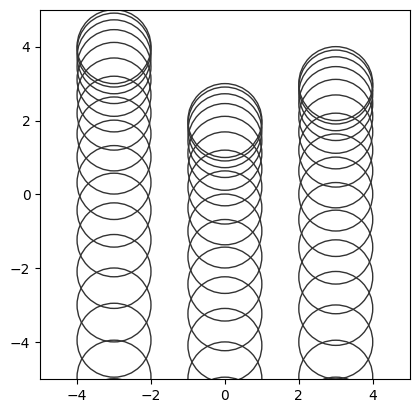

In [138]:
circles = Circle(
    mass=jnp.ones(3),
    radius=jnp.ones(3),
    moment=jnp.ones(3) * 0.5,
    elasticity=jnp.ones(3),
    friction=jnp.ones(3),
    rgba=jnp.tile(jnp.array([0.2, 0.2, 0.2, 1.0]), (3, 1)),
)
space = Space(gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.array([-2, 0.1, 0.2]).reshape(3, 1),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3]]),
)
v = Velocity.zeros(3)
f = Force.zeros(3)
state = State(p=p, v=v, f=f, is_active=jnp.ones(3, dtype=bool))
positions = [state.p]
for i in range(20):
    state = update_velocity(space, circles, state)
    state = update_position(space, state)
    positions.append(state.p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)
fig

できたっぽいですね。

## 衝突判定を行う

次に衝突判定を実装してみましょう。円と円しかないので判定自体は簡単ですが、後で衝突後の物理状態を求めるために計算するときのため、衝突した場所やそれによって発生したインパルスといった情報を保存しておく必要があります。
また、衝突判定を行う際、全てのペアについて衝突を検出するコードをナイーブに書くと、以下のようになります。
```python
for i in range(N):
    for j in range(i + 1, N):
        check_contact(i, j)
```
ですが、衝突検出は各ペアについて独立に行えるので、`jax.vmap`を使って並列化したいところです。そこで、このループを手動でアンロールし、あらかじめペアを生成してから`vmap`で並列化した衝突検出関数を呼ぶようにしました。以下のコード中の`generate_self_pairs`が全ペアを生成する関数になります。

In [139]:
from typing import Any, Callable

Axis = Sequence[int] | int


def safe_norm(x: jax.Array, axis: Axis | None = None) -> jax.Array:
    is_zero = jnp.allclose(x, 0.0)
    x = jnp.where(is_zero, jnp.ones_like(x), x)
    n = jnp.linalg.norm(x, axis=axis)
    return jnp.where(is_zero, 0.0, n)  # pyright: ignore


def normalize(x: jax.Array, axis: Axis | None = None) -> tuple[jax.Array, jax.Array]:
    norm = safe_norm(x, axis=axis)
    n = x / (norm + 1e-6 * (norm == 0.0))
    return n, norm


def tree_map2(
    f: Callable[..., Any],
    tree: Any,
    *rest: Any,
    is_leaf: Callable[[Any], bool] | None = None
) -> tuple[Any, Any]:
    """Same as tree_map, but returns a tuple"""
    leaves, treedef = jax.tree_util.tree_flatten(tree, is_leaf)
    all_leaves = [leaves] + [treedef.flatten_up_to(r) for r in rest]
    result = [f(*xs) for xs in zip(*all_leaves)]
    a = treedef.unflatten([elem[0] for elem in result])
    b = treedef.unflatten([elem[1] for elem in result])
    return a, b


def generate_self_pairs(x: jax.Array) -> tuple[jax.Array, jax.Array]:
    """Returns two arrays that iterate over all combination of elements in x and y."""
    # x.shape[0] > 1
    chex.assert_axis_dimension_gt(x, 0, 1)
    n = x.shape[0]
    # (a, a, a, b, b, c)
    outer_loop = jnp.repeat(
        x,
        jnp.arange(n - 1, -1, -1),
        axis=0,
        total_repeat_length=n * (n - 1) // 2,
    )
    # (b, c, d, c, d, d)
    inner_loop = jnp.concatenate([x[i:] for i in range(1, len(x))])
    return outer_loop, inner_loop


@chex.dataclass
class Contact(PyTreeOps):
    r1: jax.Array
    r2: jax.Array
    pos: jax.Array
    normal: jax.Array
    penetration: jax.Array
    elasticity: jax.Array
    friction: jax.Array

    def contact_dim(self) -> int:
        return self.pos.shape[1]


def _circle_to_circle_impl(
    a: Circle,
    b: Circle,
    a_pos: Position,
    b_pos: Position,
    isactive: jax.Array,
) -> Contact:
    a2b_normal, dist = normalize(b_pos.xy - a_pos.xy)
    penetration = a.radius + b.radius - dist
    a_contact = a_pos.xy + a2b_normal * a.radius
    b_contact = b_pos.xy - a2b_normal * b.radius
    pos = (a_contact + b_contact) * 0.5
    # Filter penetration
    penetration = jnp.where(isactive, penetration, jnp.ones_like(penetration) * -1)
    contact = Contact(
        r1=pos - a_pos.xy,
        r2=pos - b_pos.xy,
        pos=pos,
        normal=a2b_normal,
        penetration=penetration,
        elasticity=(a.elasticity + b.elasticity) * 0.5,
        friction=(a.friction + b.friction) * 0.5,
    )
    # Expand the dimension to (1, x) for compatibility
    return contact.expand_dims(axis=0)


def check_circle_to_circle(
    space: Space,
    position: Position,
    is_active: jax.Array,
) -> tuple[Contact, Circle, Circle]:
    circle1, circle2 = tree_map2(generate_self_pairs, space.circle)
    pos1, pos2 = tree_map2(generate_self_pairs, position)
    is_active = jnp.logical_and(*generate_self_pairs(is_active))
    contacts = jax.vmap(_circle_to_circle_impl)(circle1, circle2, pos1, pos2, is_active)
    return contacts, circle1, circle2

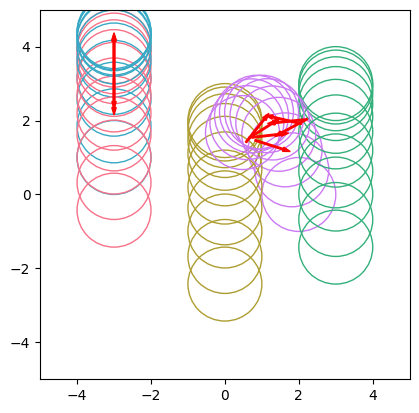

In [140]:
import seaborn as sns
from matplotlib.patches import Arrow

N = 5
palette = sns.color_palette("husl", N)


circles = Circle(
    mass=jnp.ones(N),
    radius=jnp.ones(N),
    moment=jnp.ones(N) * 0.5,
    elasticity=jnp.ones(N),
    friction=jnp.ones(N),
    rgba=jnp.array([p + (1.0,) for p in palette]),
)
space = Space(gravity=jnp.array([0.0, -9.8]), circle=circles)
p = Position(
    angle=jnp.zeros((N, 1)),
    xy=jnp.array([[-3, 4.0], [0.0, 2.0], [3.0, 3], [-3, 1], [2, 0]]),
)
v_xy = jnp.concatenate((jnp.zeros((N - 2, 2)), jnp.array([[0, 10.0], [-2.0, 8.0]])))
v = Velocity(angle=jnp.zeros(N), xy=v_xy)
f = Force(angle=jnp.zeros(N), xy=jnp.zeros((N, 2)))
state = State(p=p, v=v, f=f, is_active=jnp.ones(N, dtype=bool))
positions = [state.p]
contact_list = []
for i in range(10):
    state = update_velocity(space, circles, state)
    state = update_position(space, state)
    positions.append(state.p)
    contacts, _, _ = check_circle_to_circle(space, state.p, state.is_active)
    total_index = 0
    for j in range(N):
        for k in range(j + 1, N):
            if contacts.penetration[total_index, 0] > 0:
                contact_list.append(contacts.get_slice((total_index, 0)))
            total_index += 1
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-5, 5))
ax.set_ylim((-5, 5))
visualize_balls(ax, space.circle, positions)
for contact in contact_list:
    arrow = Arrow(*contact.pos, *contact.normal, width=0.2, color="r")
    ax.add_patch(arrow)
fig

衝突後の処理を実装していないので物体がすりぬけていますが、衝突自体はきちんと検出されているようです。

## 衝突した後どうすればいいの

衝突を検出した後は、物体が重ならないように衝突時に発生したインパルスに関する制約つき方程式を解く必要があります。そのために色々な方法があるのですが、今回は[Chipmunk](https://github.com/slembcke/Chipmunk2D)など2次元物理エンジンでよく使われている[Sequential Impulse](https://box2d.org/files/ErinCatto_SequentialImpulses_GDC2006.pdf)と呼ばれる方法を使ってみます。なお、この資料は[Box2D](https://box2d.org)のWebページで公開されているものです。

では、Sequential Impulseではどのようにして衝突を解決するのでしょうか。まず、物体の衝突時にインパルスが発生するという衝突モデルを仮定し、発生したインパルスを$\mathbf{p}$とおきます。面倒なので角速度は一切考えないことにします。このとき、物体1の速度を$\mathbf{v}_1$、質量を$m_1$、物体2の速度を$\mathbf{v}_2$、質量を$m_2$とおくと、インパルスが発生した後の速度は
$$
\begin{align*}
\mathbf{v}_1 = \mathbf{v}_1^{\mathrm{old}} - \mathbf{p} / m_1 \\
\mathbf{v}_2 = \mathbf{v}_2^{\mathrm{old}} + \mathbf{p} / m_2
\end{align*}
$$
となります。このとき、$\mathbf{p}$の方向は衝突の法線ベクトル$\mathbf{n}$なので$\mathbf{p} = p\mathbf{n}$と表せます。よって、結局$p$を求めればいいです。衝突した点における相対速度を$\Delta \mathbf{v} = \mathbf{v}_2 - \mathbf{v}_1$とおきます。このとき、$\Delta \mathbf{v} \cdot n = 0$なので、上の2式と合わせて、$p = \frac{-\Delta \mathbf{v}^{\mathrm{old}}\cdot \mathbf{n}}{\frac{1}{m_1} + \frac{1}{m_2}}$となります。角速度や摩擦を考慮するともう少しややこしくなりますが、基本はこんな感じです。

こうして計算したインパルスを全ての衝突に対して適用し、インパルスが小さくなるまで繰り返します。しかし、この手法は物体のめりこみを考慮していないので、これだけだと物体がめりこんだままになってしまうことがあります。
めり込みを減らすための手法はいくつかありますが、どのくらいめり込んでいるかに応じてバイアス速度$v_\mathrm{bias} = \frac{\beta}{\Delta t}\max(0, \delta - \delta_\mathrm{slop})$($\delta$はめりこみの長さ、$\delta_\mathrm{slop}$は許容されるめりこみの長さ)を加え$p = \frac{-\Delta \mathbf{v}^{\mathrm{old}}\cdot \mathbf{n} + v_\mathrm{bias}}{\frac{1}{m_1} + \frac{1}{m_2}}$とするのが一般的なようです。先程紹介したBox2Dの資料やChipmunk2Dでこれが使われています。この手法は非常に高速な一方、衝突の際に人工的なモーメンタムを加えるため、ジョイントが不安定性になりがちという欠点があります。これを避けるには、インパルスの計算が終わった後に別にPositionに関する制約を解く必要があります。この手法はNonlinear Gauss Seidel(NGS)と呼ばれ、現在のBox2Dではこれが使われているようです。詳しくは[Box2D 3.0のコメント](https://github.com/erincatto/box2c/blob/a0a9c6e72c9f2174fdf6582c5d4ba60f5343b2ba/src/island.c#L27)を参照してください。しかし、NGSでは各イテレーションでめりこみの計算を繰り返す必要があり、おそらく倍以上遅くなるので、ここではバイアス速度だけを使う方法を実装してみます。[^1]

また、さっき並列化のため手動で全ペアに対するループをアンロールしましたが、Sequential Impulseの実装でもこれが使えます。ただし、インパルスを加えた後の速度の更新は、`v_update[i][j]`に`i`番目の物体と`j`番目の物体の衝突により生じる`i`番目の物体の速度変化が入っているとして、
```python
for i in range(N):
    for j in range(i + 1, N):
        obj[i].velocity += v_update[i][j]
        obj[j].velocity += v_update[j][i]
```
のように各衝突により生じた速度変化を物体にフィードバックする必要があります。これもいちいちループで書くと遅くなってしまうのですが、さっきの`generate_self_pairs`で$0, 1, 2, ..., N - 1$のペアを生成しておいてインデックスにするとループなしで書けます。細かく言うと、`generate_self_pairs`ではループが使われているのですが、`jax.jit`でコンパイルした時に計算結果がキャッシュされるはずなので気にしなくてもいいです。

というわけで実装してみましょう。実装は基本的に[Box2d-Lite](https://github.com/erincatto/box2d-lite)を参考にしましたが、開発中の最新版である[Box2D 3.0](https://github.com/erincatto/box2c)も部分的に参考にしています。

[^1]: ちなみに、この手法の正確な呼び方はよくわかりませんが、上記のBox2DのコメントではBaumgarteと呼ばれています。バイアス速度を加える部分が「Baumgarteの安定化法」と呼ばれるためだと思いますが、NGSでもこの項を入れることがあるようです。

In [166]:
@chex.dataclass
class ContactHelper(PyTreeOps):
    tangent: jax.Array
    mass_normal: jax.Array
    mass_tangent: jax.Array
    v_bias: jax.Array
    bounce: jax.Array
    inv_mass1: jax.Array
    inv_mass2: jax.Array
    inv_moment1: jax.Array
    inv_moment2: jax.Array
    allow_bounce: jax.Array


@chex.dataclass
class ContactSolver(PyTreeOps):
    v1: Velocity
    v2: Velocity
    pn: jax.Array
    pt: jax.Array
    contact: jax.Array

    def update(self, new_contact: jax.Array) -> Self:
        continuing_contact = jnp.logical_and(self.contact, new_contact)
        pn = jnp.where(continuing_contact, self.pn, jnp.zeros_like(self.pn))
        pt = jnp.where(continuing_contact, self.pn, jnp.zeros_like(self.pt))
        return self.replace(pn=pn, pt=pt, contact=new_contact)


def init_solver(n: int) -> ContactSolver:
    return ContactSolver(
        v1=Velocity.zeros(n),
        v2=Velocity.zeros(n),
        pn=jnp.zeros((n, 1)),
        pt=jnp.zeros((n, 1)),
        contact=jnp.zeros((n, 1), dtype=bool),
    )


def _v_gather1(v1: Velocity, v2: Velocity, orig_v: Velocity) -> Velocity:
    indices = jnp.arange(len(orig_v.angle))
    outer, inner = generate_self_pairs(indices)
    v1_xy = jnp.zeros_like(orig_v.xy).at[outer].add(v1.xy)
    v1_angle = jnp.zeros_like(orig_v.angle).at[outer].add(v1.angle)
    v2_xy = jnp.zeros_like(orig_v.xy).at[inner].add(v2.xy)
    v2_angle = jnp.zeros_like(orig_v.angle).at[inner].add(v2.angle)
    return Velocity(xy=v1_xy, angle=v1_angle) + Velocity(xy=v2_xy, angle=v2_angle)


def _v_pairs1(v: Velocity, n_repeats: int) -> tuple[Velocity, Velocity]:
    v1_angle, v2_angle = generate_self_pairs(v.angle)
    v1_xy, v2_xy = generate_self_pairs(v.xy)
    v1 = Velocity(
        angle=jnp.tile(jnp.expand_dims(v1_angle, axis=1), (1, n_repeats)),
        xy=jnp.tile(jnp.expand_dims(v1_xy, axis=1), (1, n_repeats, 1)),
    )
    v2 = Velocity(
        angle=jnp.tile(jnp.expand_dims(v2_angle, axis=1), (1, n_repeats)),
        xy=jnp.tile(jnp.expand_dims(v2_xy, axis=1), (1, n_repeats, 1)),
    )
    return v1, v2


def _vmap_dot(xy1: jax.Array, xy2: jax.Array) -> jax.Array:
    """Dot product between nested vectors"""
    chex.assert_equal_shape((xy1, xy2))
    orig_shape = xy1.shape
    a = xy1.reshape(-1, orig_shape[-1])
    b = xy2.reshape(-1, orig_shape[-1])
    return jax.vmap(jnp.dot, in_axes=(0, 0))(a, b).reshape(*orig_shape[:-1])


def _sv_cross(s: jax.Array, v: jax.Array) -> jax.Array:
    """Cross product with scalar and vector"""
    x, y = _get_xy(v)
    return jnp.stack((x * -s, y * s), axis=-1)


def _dv2from1(v1: Velocity, r1: jax.Array, v2: Velocity, r2: jax.Array) -> jax.Array:
    """Compute relative veclotiy from v2/r2 to v1/r1"""
    rel_v1 = v1.xy + _sv_cross(v1.angle, r1)
    rel_v2 = v2.xy + _sv_cross(v2.angle, r2)
    return rel_v2 - rel_v1


def init_contact_helper(
    space: Space,
    contact: Contact,
    a: Shape,
    b: Shape,
    v1: Velocity,
    v2: Velocity,
) -> ContactHelper:
    def rn2(r: jax.Array, n: jax.Array) -> jax.Array:
        return jnp.cross(r, n) ** 2

    inv_mass1 = jnp.expand_dims(a.inv_mass(), axis=-1)
    inv_moment1 = jnp.expand_dims(a.inv_moment(), axis=-1)
    inv_mass2 = jnp.expand_dims(b.inv_mass(), axis=-1)
    inv_moment2 = jnp.expand_dims(b.inv_moment(), axis=-1)
    k_normal = (
        inv_mass1
        + inv_moment1 * rn2(contact.r1, contact.normal)
        + inv_mass2
        + inv_moment2 * rn2(contact.r2, contact.normal)
    )
    nx, ny = _get_xy(contact.normal)
    tangent = jnp.stack((-ny, nx), axis=-1)
    k_tangent = (
        inv_mass1
        + inv_moment1 * rn2(contact.r1, tangent)
        + inv_mass2
        + inv_moment2 * rn2(contact.r2, tangent)
    )
    clipped_p = jnp.clip(space.allowed_penetration - contact.penetration, a_max=0.0)
    v_bias = -space.bias_factor / space.dt * clipped_p
    # k_normal, k_tangent, and v_bias should have (N(N-1)/2, N_contacts) shape
    chex.assert_equal_shape((contact.friction, k_normal, k_tangent, v_bias))
    # Compute elasiticity * relative_vel
    dv = _dv2from1(v1, contact.r1, v2, contact.r2)
    vn = _vmap_dot(dv, contact.normal)
    return ContactHelper(
        tangent=tangent,
        mass_normal=1 / k_normal,
        mass_tangent=1 / k_tangent,
        v_bias=v_bias,
        bounce=vn * contact.elasticity,
        inv_mass1=inv_mass1,
        inv_mass2=inv_mass2,
        inv_moment1=inv_moment1,
        inv_moment2=inv_moment2,
        allow_bounce=dv <= -space.bounce_threshold,
    )


def apply_velocity_normal(
    contact: Contact,
    helper: ContactHelper,
    solver: ContactSolver,
) -> ContactSolver:
    """
    Apply velocity constraints to the solver.
    Suppose that each shape has (N_contact, 1) or (N_contact, 2).
    """
    # Relative veclocity (from shape2 to shape1)
    dv = _dv2from1(solver.v1, contact.r1, solver.v2, contact.r2)
    vt = _vmap_dot(dv, helper.tangent)
    dpt = -helper.mass_tangent * vt
    # Clamp friction impulse
    max_pt = contact.friction * solver.pn
    pt = jnp.clip(solver.pt + dpt, a_min=-max_pt, a_max=max_pt)
    dpt_clamped = helper.tangent * (pt - solver.pt)
    # Velocity update by contact tangent
    dvt1 = Velocity(
        angle=-helper.inv_moment1 * jnp.cross(contact.r1, dpt_clamped),
        xy=-dpt_clamped * helper.inv_mass1,
    )
    dvt2 = Velocity(
        angle=helper.inv_moment2 * jnp.cross(contact.r2, dpt_clamped),
        xy=dpt_clamped * helper.inv_mass2,
    )
    # Compute Relative velocity again
    dv = _dv2from1(solver.v1 + dvt1, contact.r1, solver.v2 + dvt2, contact.r2)
    vn = _vmap_dot(dv, contact.normal)
    # Impulse = (vn + bounce + v_bias) / m
    dpn = helper.mass_normal * (-vn + helper.v_bias)
    # Accumulate and clamp impulse
    pn = jnp.clip(solver.pn + dpn, a_min=0.0)
    dpn_clamped = contact.normal * (pn - solver.pn)
    # Velocity update by contact normal
    dvn1 = Velocity(
        angle=-helper.inv_moment1 * jnp.cross(contact.r1, dpn_clamped),
        xy=-dpn_clamped * helper.inv_mass1,
    )
    dvn2 = Velocity(
        angle=helper.inv_moment2 * jnp.cross(contact.r2, dpn_clamped),
        xy=dpn_clamped * helper.inv_mass2,
    )
    # Filter dv
    dv1, dv2 = jax.tree_map(
        lambda x: jnp.where(solver.contact, x, jnp.zeros_like(x)),
        (dvn1 + dvt2, dvn2 + dvt2),
    )
    # Summing up dv per each contact pair
    return ContactSolver(
        v1=dv1.sum(axis=0),
        v2=dv2.sum(axis=0),
        pn=pn,
        pt=pt,
        contact=solver.contact,
    )


def apply_bounce(
    contact: Contact,
    helper: ContactHelper,
    solver: ContactSolver,
) -> tuple[Velocity, Velocity]:
    """ Apply bounce (resititution). Suppose that each shape has (N_contact, 1) or (N_contact, 2).
    """
    # Relative veclocity (from shape2 to shape1)
    dv = _dv2from1(solver.v1, contact.r1, solver.v2, contact.r2)
    vn = _vmap_dot(dv, contact.normal)
    pn = -helper.mass_normal * (vn + helper.bounce)
    dpn = contact.normal * pn
    # Velocity update by contact normal
    dv1 = Velocity(
        angle=-helper.inv_moment1 * jnp.cross(contact.r1, dpn),
        xy=-dpn * helper.inv_mass1,
    )
    dv2 = Velocity(
        angle=helper.inv_moment2 * jnp.cross(contact.r2, dpn),
        xy=dpn * helper.inv_mass2,
    )
    # Filter dv
    allow_bounce = jnp.logical_and(solver.contact, helper.allow_bounce)
    dv1, dv2 = jax.tree_map(
        lambda x: jnp.where(allow_bounce, x, jnp.zeros_like(x)),
        (dv1, dv2),
    )
    # Summing up dv per each contact pair
    return dv1.sum(axis=0), dv2.sum(axis=0)


def apply_seq_impulses(
    space: Space,
    solver: ContactSolver,
    v: Velocity,
    contact: Contact,
    a: Shape,
    b: Shape,
) -> tuple[Velocity, ContactSolver]:
    """Resolve collisions by Sequential Impulse method"""
    v1, v2 = _v_pairs1(v, n_repeats=contact.contact_dim())
    helper = init_contact_helper(space, contact, a, b, v1, v2)
    solver = solver.replace(v1=v1, v2=v2)
    print("Pene: ", contact.penetration[6])
    def step(
        _n_iter: int,
        vs: tuple[Velocity, ContactSolver],
    ) -> tuple[Velocity, ContactSolver]:
        v_i, solver_i = vs
        print("n_iter: ", _n_iter, "pn: ", solver_i.pn[6], "dv: ", solver_i.v1.angle[6], solver_i.v1.xy[6])
        solver_i1 = jax.vmap(apply_velocity_normal)(contact, helper, solver_i)
        v_i1 = _v_gather1(solver_i1.v1, solver_i1.v2, v_i) + v_i
        v1, v2 = _v_pairs1(v_i1, n_repeats=contact.contact_dim())
        return v_i1, solver_i1.replace(v1=v1, v2=v2)

    v, solver = fake_fori_loop(0, space.n_solver_iter, step, (v, solver))
    #rest_v1, rest_v2 = apply_restituition(contact, helper, solver)
    #v = _v_gather1(rest_v1, rest_v2, v) + v
    return v, solver

なかなか複雑になりましたが、実装できました。衝突させてみましょう。

In [167]:
from celluloid import Camera
from IPython.display import HTML


def animate_balls(
    fig,
    ax: Axes,
    circles: Circle,
    positions: Iterable[Position],
) -> HTML:
    pos = list(positions)
    camera = Camera(fig)
    circle_list = circles.tolist()
    for pi in pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)
        camera.snap()
    return HTML(camera.animate().to_html5_video())

In [168]:
space = Space(gravity=jnp.array([0.0, -9.8]), dt=0.04, bias_factor=0.2, circle=circles)
state = State(p=p, v=v, f=f, is_active=jnp.ones(N, dtype=bool))
positions = [state.p]
solver = init_solver(N * (N - 1) // 2)


# @jax.jit
def step(state: State, solver: ContactSolver) -> tuple[State, ContactSolver]:
    state = update_velocity(space, space.circle, state)
    contacts, c1, c2 = check_circle_to_circle(space, state.p, state.is_active)
    solver = solver.update(contacts.penetration >= 0)
    v, solver = apply_seq_impulses(
        space,
        solver.update(contacts.penetration >= 0),
        state.v,
        contacts,
        c1,
        c2,
    )
    return update_position(space, state.replace(v=v)), solver


for i in range(10):
    state, solver = step(state, solver)
    positions.append(state.p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
animate_balls(fig, ax, space.circle, positions)

Pene:  [-0.8284271]
n_iter:  0 pn:  [0.] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  1 pn:  [3.358757] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  2 pn:  [6.717514] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  3 pn:  [10.076271] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  4 pn:  [13.435028] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  5 pn:  [16.793785] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  6 pn:  [20.152542] vn:  [0.] [[ 0.     -0.3724]]
n_iter:  7 pn:  [23.5113] vn:  [0.] [[ 0.     -0.3724]]
Pene:  [-0.5647986]
n_iter:  0 pn:  [0.] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  1 pn:  [3.064166] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  2 pn:  [5.9251933] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  3 pn:  [8.786221] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  4 pn:  [11.647247] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  5 pn:  [14.508275] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  6 pn:  [17.369303] vn:  [0.] [[ 0.      -0.72618]]
n_iter:  7 pn:  [20.23033] vn:  [0.] [[ 0.      -0.72618]]
Pene:  [-0.32580638]
n_iter:  0 pn:  

$\Delta t = 0.04$のわりに速度が速すぎるので左のボールは微妙にめりこんでいますが、一応大丈夫そうですね。

## 線分
円同士の衝突が実装できたところで、次は凸多角形の実装...と言いたいところですが、それは後回しにして、ゲームには欠かせない「線分」を実装してみます。現実世界にはそんなもの存在しないのですが、ゲームやシミュレーションの世界では、どうしても地面や柵といった境界を表現する必要が生じてきます。こういったものを例えば「めちゃくちゃ重い長方形」として表現することもできますが、シミュレーションを組むユーザー側からするといちいち長方形の大きさだったりを定義するのは面倒なので、「無限の質量を持つ線」として扱えたほうが楽ですよね。というわけで線分を実装してみます。線分の衝突判定は薬のカプセル💊のように両端が丸くなっているやつ(Box2Dだとカプセルと呼ばれているのでカプセルと呼びます)と実装がほぼ同じなので、カプセルも一緒に実装してしまいます。ただカプセル同士の衝突は面倒なので、とりあえず円とカプセルだけ実装しましょう。新しい図形を加えたので、`Space`も作り直す必要があります。`TypedDict`で全シェイプを持つことにしましょう。

In [12]:
import functools
from typing import TypedDict


@chex.dataclass
class Capsule(Shape):
    length: jax.Array
    radius: jax.Array


@chex.dataclass
class Segment(Shape):
    length: jax.Array

    def to_capsule(self) -> Capsule:
        return Capsule(
            mass=self.mass,
            moment=self.moment,
            elasticity=self.elasticity,
            friction=self.friction,
            rgba=self.rgba,
            length=self.length,
            radius=jnp.zeros_like(self.length),
        )


def _length_to_points(length: jax.Array) -> tuple[jax.Array, jax.Array]:
    a = jnp.stack((length * -0.5, length * 0.0), axis=-1)
    b = jnp.stack((length * 0.5, length * 0.0), axis=-1)
    return a, b


def _capsule_to_circle_impl(
    a: Capsule,
    b: Circle,
    a_pos: Position,
    b_pos: Position,
    isactive: jax.Array,
) -> Contact:
    # Move b_pos to capsule's coordinates
    pb = a_pos.inv_transform(b_pos.xy)
    p1, p2 = _length_to_points(a.length)
    edge = p2 - p1
    s1 = jnp.dot(pb - p1, edge)
    s2 = jnp.dot(p2 - pb, edge)
    in_segment = jnp.logical_and(s1 >= 0.0, s2 >= 0.0)
    ee = jnp.sum(jnp.square(edge), axis=-1, keepdims=True)
    # Closest point
    # s1 < 0: pb is left to the capsule
    # s2 < 0: pb is right to the capsule
    # else: pb is in between capsule
    pa = jax.lax.select(
        in_segment,
        p1 + edge * s1 / ee,
        jax.lax.select(s1 < 0.0, p1, p2),
    )
    a2b_normal, dist = normalize(pb - pa)
    penetration = a.radius + b.radius - dist
    a_contact = pa + a2b_normal * a.radius
    b_contact = pb - a2b_normal * b.radius
    pos = a_pos.transform((a_contact + b_contact) * 0.5)
    xy_zeros = jnp.zeros_like(b_pos.xy)
    a2b_normal_rotated = a_pos.replace(xy=xy_zeros).transform(a2b_normal)
    # Filter penetration
    penetration = jnp.where(isactive, penetration, jnp.ones_like(penetration) * -1)
    contact = Contact(
        r1=pos - a_pos.xy,
        r2=pos - b_pos.xy,
        pos=pos,
        normal=a2b_normal_rotated,
        penetration=penetration,
        elasticity=(a.elasticity + b.elasticity) * 0.5,
        friction=(a.friction + b.friction) * 0.5,
    )
    # Expand the dimension to (1, x) for compatibility
    return contact.expand_dims(axis=0)


class ShapeDict(TypedDict, total=False):
    circle: Circle
    segment: Segment
    capsule: Capsule


class StateDict(TypedDict, total=False):
    circle: State
    segment: State
    capsule: State


ContactFn = Callable[[StateDict], tuple[Contact, Shape, Shape]]


def _pair_outer(x: jax.Array, reps: int):
    return jnp.repeat(x, reps, axis=0, total_repeat_length=x.shape[0] * reps)


def _pair_inner(x: jax.Array, reps: int):
    return jnp.tile(x, (reps,) + (1,) * (x.ndim - 1))


def generate_pairs(x: jax.Array, y: jax.Array) -> tuple[jax.Array, jax.Array]:
    """Returns two arrays that iterate over all combination of elements in x and y"""
    xlen, ylen = x.shape[0], y.shape[0]
    return _pair_outer(x, ylen), _pair_inner(y, xlen)


def _circle_to_circle(shaped, stated: StateDict) -> tuple[Contact, Circle, Circle]:
    circle1, circle2 = tree_map2(generate_self_pairs, space.shaped["circle"])
    pos1, pos2 = tree_map2(generate_self_pairs, stated["circle"].p)
    is_active = jnp.logical_and(*generate_self_pairs(stated["circle"].is_active))
    contacts = jax.vmap(_circle_to_circle_impl)(
        circle1,
        circle2,
        pos1,
        pos2,
        is_active,
    )
    return contacts, circle1, circle2


def _capsule_to_circle(shaped, stated: StateDict) -> tuple[Contact, Capsule, Circle]:
    capsule = jax.tree_map(
        functools.partial(_pair_outer, reps=shaped["circle"].mass.shape[0]),
        shaped["capsule"],
    )
    circle = jax.tree_map(
        functools.partial(_pair_inner, reps=shaped["capsule"].mass.shape[0]),
        shaped["circle"],
    )
    pos1, pos2 = tree_map2(generate_pairs, stated["capsule"].p, stated["circle"].p)
    is_active = jnp.logical_and(
        *generate_pairs(stated["capsule"].is_active, stated["circle"].is_active)
    )
    contacts = jax.vmap(_capsule_to_circle_impl)(
        capsule,
        circle,
        pos1,
        pos2,
        is_active,
    )
    return contacts, capsule, circle


def _segment_to_circle(shaped, stated: StateDict) -> tuple[Contact, Segment, Circle]:
    segment = jax.tree_map(
        functools.partial(_pair_outer, reps=shaped["circle"].mass.shape[0]),
        shaped["segment"],
    )
    circle = jax.tree_map(
        functools.partial(_pair_inner, reps=shaped["segment"].mass.shape[0]),
        shaped["circle"],
    )
    pos1, pos2 = tree_map2(generate_pairs, stated["segment"].p, stated["circle"].p)
    is_active = jnp.logical_and(
        *generate_pairs(stated["segment"].is_active, stated["circle"].is_active)
    )
    contacts = jax.vmap(_capsule_to_circle_impl)(
        segment.to_capsule(),
        circle,
        pos1,
        pos2,
        is_active,
    )
    return contacts, segment, circle


_CONTACT_FUNCTIONS = {
    ("circle", "circle"): _circle_to_circle,
    ("capsule", "circle"): _capsule_to_circle,
    ("segment", "circle"): _segment_to_circle,
}


@chex.dataclass
class ExtendedSpace:
    gravity: jax.Array
    shaped: ShapeDict
    dt: jax.Array | float = 0.1
    linear_damping: jax.Array | float = 0.95
    angular_damping: jax.Array | float = 0.95
    bias_factor: jax.Array | float = 0.2
    n_solver_iter: int = 8
    allowed_penetration: jax.Array | float = 0.005

    def check_contacts(self, stated: StateDict) -> dict[tuple[str, str], Any]:
        ret = {}
        for (n1, n2), fn in _CONTACT_FUNCTIONS.items():
            if n1 in stated and n2 in stated:
                ret[n1, n2] = fn(self.shaped, stated)
        return ret

試してみましょう。

In [13]:
from matplotlib.patches import Rectangle


def animate_balls_and_segments(
    fig,
    ax: Axes,
    circles: Circle,
    segments: Segment,
    c_pos: Iterable[Position],
    s_pos: Position,
) -> HTML:
    camera = Camera(fig)
    circle_list = circles.tolist()
    # Lower left
    segment_ll = s_pos.transform(
        jnp.stack((-segments.length * 0.5, jnp.zeros_like(segments.length)), axis=1)
    )
    for pi in c_pos:
        for pij, circle in zip(pi.tolist(), circle_list):
            circle_patch = CirclePatch(
                xy=pij.xy,
                radius=circle.radius,
                fill=False,
                color=circle.rgba.tolist(),
            )
            ax.add_patch(circle_patch)
        for ll, pj, segment in zip(segment_ll, s_pos.tolist(), segments.tolist()):
            rect_patch = Rectangle(
                xy=ll,
                width=segment.length,
                angle=(pj.angle / jnp.pi).item() * 180,
                height=0.1,
            )
            ax.add_patch(rect_patch)
        camera.snap()
    return HTML(camera.animate().to_html5_video())

In [23]:
ContactDict = dict[tuple[str, str], tuple[Contact, Shape, Shape]]
SolverDict = dict[tuple[str, str], ContactSolver]


class VelocityDict(TypedDict, total=False):
    circle: Velocity
    segment: Velocity
    capsule: Velocity


def _v_gather2(
    solver: ContactSolver,
    orig_v1: Velocity,
    orig_v2: Velocity,
) -> tuple[Velocity, Velocity]:
    idx1, idx2 = jnp.arange(len(orig_v1.angle)), jnp.arange(len(orig_v2.angle))
    outer, inner = generate_pairs(idx1, idx2)
    v1_xy = jnp.zeros_like(orig_v1.xy).at[outer].add(solver.v1.xy)
    v1_angle = jnp.zeros_like(orig_v1.angle).at[outer].add(solver.v1.angle)
    v2_xy = jnp.zeros_like(orig_v2.xy).at[inner].add(solver.v2.xy)
    v2_angle = jnp.zeros_like(orig_v2.angle).at[inner].add(solver.v2.angle)
    return Velocity(xy=v1_xy, angle=v1_angle), Velocity(xy=v2_xy, angle=v2_angle)


def _v_pairs2(v1: Velocity, v2: Velocity, n_repeats: int) -> tuple[Velocity, Velocity]:
    v1_angle, v2_angle = generate_pairs(v1.angle, v2.angle)
    v1_xy, v2_xy = generate_pairs(v1.xy, v2.xy)
    v1 = Velocity(
        angle=jnp.tile(jnp.expand_dims(v1_angle, axis=1), (1, n_repeats)),
        xy=jnp.tile(jnp.expand_dims(v1_xy, axis=1), (1, n_repeats, 1)),
    )
    v2 = Velocity(
        angle=jnp.tile(jnp.expand_dims(v2_angle, axis=1), (1, n_repeats)),
        xy=jnp.tile(jnp.expand_dims(v2_xy, axis=1), (1, n_repeats, 1)),
    )
    return v1, v2


def fake_fori_loop(start, end, step, initial):
    state = initial
    for i in range(start, end):
        state = step(i, state)
    return state


def apply_seqi_general(space: Space, cd: ContactDict, vd: VelocityDict) -> VelocityDict:
    """Resolve collisions by Sequential Impulse method"""
    solverd, helperd = {}, {}
    for (k1, k2), (contact, s1, s2) in cd.items():
        if k1 == k2:  # Self contact
            v1, v2 = _v_pairs1(vd[k1], n_repeats=contact.contact_dim())
        else:
            v1, v2 = _v_pairs2(vd[k1], vd[k2], n_repeats=contact.contact_dim())
        helperd[k1, k2] = init_contact_helper(space, contact, s1, s2, v1, v2)
        # TODO: warm starting solver by applying the initial impulse
        solverd[k1, k2] = ContactSolver(
            v1=v1,
            v2=v2,
            pn=jnp.zeros_like(contact.friction),
            pt=jnp.zeros_like(contact.friction),
        )

    def step(
        _n_iter: int,
        vs: tuple[VelocityDict, SolverDict],
    ) -> tuple[VelocityDict, SolverDict]:
        v_i, solver_i = vs
        solver_i1 = {
            key: jax.vmap(step_solver)(contact, helperd[key], solver_i[key])
            for key, (contact, _, _) in cd.items()
        }
        for (k1, k2), (solver, _) in solver_i1.items():
            if k1 == k2:
                v_i[k1] = v_i[k1] + _v_gather1(solver, v_i[k1])
            else:
                vd1, vd2 = _v_gather2(solver, v_i[k1], v_i[k2])
                v_i[k1] = v_i[k1] + vd1
                v_i[k2] = v_i[k2] + vd2
        for (k1, k2), (solver, _) in solver_i1.items():
            cdim = cd[k1, k2][0].contact_dim()
            if k1 == k2:
                v1, v2 = _v_pairs1(v_i[k1], n_repeats=cdim)
            else:
                v1, v2 = _v_pairs2(v_i[k1], v_i[k2], n_repeats=cdim)
            solver.v1 = v1
            solver.v2 = v2
        # print(v_i)
        return v_i, solver_i1

    ret = fake_fori_loop(0, 1, step, (vd, solverd))
    return ret[0]


segments = Segment(
    mass=jnp.ones(2) * jnp.inf,
    moment=jnp.ones(2) * jnp.inf,
    elasticity=jnp.ones(2),
    friction=jnp.ones(2),
    rgba=jnp.ones((2, 4)),
    length=jnp.array([4, jnp.sqrt(2) * 4]),
)
cpos = jnp.array([[2, 2], [4, 3], [3, 6], [6, 5], [5, 7]])
stated = StateDict(
    circle=State(
        p=Position(xy=cpos, angle=jnp.zeros(N)),
        v=Velocity.zeros(N),
        f=Force.zeros(N),
        is_active=jnp.ones(N, dtype=bool),
    ),
    segment=State(
        p=Position(xy=jnp.array([[2, 0], [6, 2]]), angle=jnp.array([0, jnp.pi / 4])),
        v=Velocity.zeros(2),
        f=Force.zeros(2),
        is_active=jnp.ones(2, dtype=bool),
    ),
)
space = ExtendedSpace(
    gravity=jnp.array([0.0, -9.8]),
    linear_damping=1.0,
    angular_damping=1.0,
    dt=0.04,
    shaped=ShapeDict(circle=circles, segment=segments),
)


# @jax.jit
def step(stated: StateDict) -> StateDict:
    stated = {
        name: update_velocity(space, space.shaped[name], state)
        for name, state in stated.items()
    }
    contactd = space.check_contacts(stated)
    print("Penetration!: ", contactd["segment", "circle"][0].penetration[6])
    vd = apply_seqi_general(
        space,
        contactd,
        {name: state.v for name, state in stated.items()},
    )
    return {
        name: update_position(space, state.replace(v=vd[name]))
        for name, state in stated.items()
    }


positions = [stated["circle"].p]
for i in range(20):
    stated = step(stated)
    positions.append(stated["circle"].p)
fig, ax = plt.subplots()
ax.set_aspect("equal", adjustable="box")
ax.set_xlim((0, 10))
ax.set_ylim((0, 10))
animate_balls_and_segments(
    fig,
    ax,
    space.shaped["circle"],
    space.shaped["segment"],
    positions,
    stated["segment"].p,
)

Penetration!:  [[-1.       ]
 [-2.       ]
 [-5.       ]
 [-4.3851647]
 [-6.071068 ]
 [-1.8284273]
 [-1.1213205]
 [-3.949747 ]
 [-1.1213202]
 [-3.2426405]]
Penetration!:  [[-0.98432004]
 [-1.9843197 ]
 [-4.98432   ]
 [-4.3706093 ]
 [-6.055546  ]
 [-1.8173611 ]
 [-1.1102328 ]
 [-3.9386606 ]
 [-1.1102333 ]
 [-3.231554  ]]
Penetration!:  [[-0.95296  ]
 [-1.95296  ]
 [-4.95296  ]
 [-4.341518 ]
 [-6.0245037]
 [-1.7953625]
 [-1.088058 ]
 [-3.9164858]
 [-1.0880585]
 [-3.2093787]]
Penetration!:  [[-0.90592  ]
 [-1.90592  ]
 [-4.90592  ]
 [-4.297929 ]
 [-5.977946 ]
 [-1.7627034]
 [-1.0547957]
 [-3.8832235]
 [-1.054796 ]
 [-3.1761165]]
Penetration!:  [[-0.8432001]
 [-1.8432   ]
 [-4.8432   ]
 [-4.2399035]
 [-5.9158792]
 [-1.7198133]
 [-1.0104461]
 [-3.8388739]
 [-1.0104465]
 [-3.1317668]]
Penetration!:  [[-0.7648001 ]
 [-1.7648001 ]
 [-4.7648    ]
 [-4.1675253 ]
 [-5.8383126 ]
 [-1.6673055 ]
 [-0.95500875]
 [-3.7834363 ]
 [-0.9550092 ]
 [-3.0763297 ]]
Penetration!:  [[-0.6707201]
 [-1.6707201]
 